# UCI Bank Marketing Dataset and Segmentation Analysis

The **UCI Bank Marketing dataset** consists of information collected from direct marketing campaigns by a Portuguese bank, aimed at predicting customer responses to term deposit offers. To improve marketing precision, we focus on segmenting the customer base using advanced machine learning techniques.

## Problem Context
- The dataset includes features like **age**, **job**, **marital status**, **education**, and **previous marketing outcomes**.
- The primary goal is to predict whether a customer will subscribe to a term deposit, based on these features.

## Challenges with Current Segmentation Methods
- **Traditional segmentation** techniques may fail to account for the complex relationships within customer data.
- Generalized strategies often result in missed opportunities for personalized marketing, reducing the effectiveness of campaigns.

## Problem Statement
- **How can we improve customer segmentation** to enhance marketing effectiveness and increase subscription rates for term deposits?

## Machine Learning Solution: Gaussian Mixture Model (GMM)
- We propose using **Gaussian Mixture Models (GMM)** to identify distinct customer clusters.
- GMM captures the **probabilistic distribution** of customer features, allowing for the identification of hidden patterns that simpler models might miss.
- By applying GMM, we aim to **uncover latent customer segments** and enable more targeted, data-driven marketing strategies.

## Benefits of the GMM Approach
- **Flexible Clustering**: GMM allows clusters of different shapes and sizes, capturing the true complexity of the data.
- **Customer-Centric Marketing**: GMM-based segmentation results in more personalized marketing efforts, aligning campaigns with specific customer needs and behaviors.
- **Increased Subscription Rates**: By targeting the right customers with tailored offers, we expect a boost in term deposit subscriptions.

## Conclusion
- Implementing **GMM for customer segmentation** enables a deeper understanding of customer behavior, facilitating more effective, personalized marketing.
- This approach can lead to improved **customer engagement** and ultimately drive higher **subscription rates** for the bank’s term deposit offers.


In [104]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

## 1. Load and Explore Data

In [74]:
df_bank= pd.read_csv('bank-full.csv', sep= ';')
df_addi= pd.read_csv('bank-additional-full.csv', sep= ';')
df_bank.rename(columns= {'month': 'bank_month'}, inplace= True)

df= pd.merge(df_addi, df_bank[["age", "job", "marital", "education", "balance", 'day', 'bank_month']], on= ["age", "job", "marital", "education"], how='inner')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,balance,day,bank_month
0,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,225,7,may
1,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,31,12,may
2,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1057,14,may
3,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,732,16,may
4,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,665,19,may


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8529 entries, 0 to 8528
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             8529 non-null   int64  
 1   job             8529 non-null   object 
 2   marital         8529 non-null   object 
 3   education       8529 non-null   object 
 4   default         8529 non-null   object 
 5   housing         8529 non-null   object 
 6   loan            8529 non-null   object 
 7   contact         8529 non-null   object 
 8   month           8529 non-null   object 
 9   day_of_week     8529 non-null   object 
 10  duration        8529 non-null   int64  
 11  campaign        8529 non-null   int64  
 12  pdays           8529 non-null   int64  
 13  previous        8529 non-null   int64  
 14  poutcome        8529 non-null   object 
 15  emp.var.rate    8529 non-null   float64
 16  cons.price.idx  8529 non-null   float64
 17  cons.conf.idx   8529 non-null   f

## 2. Checking the Missing Values

In [76]:
df.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
balance           0
day               0
bank_month        0
dtype: int64

In [77]:
df= df.drop_duplicates()

## 3. Exploratory Data

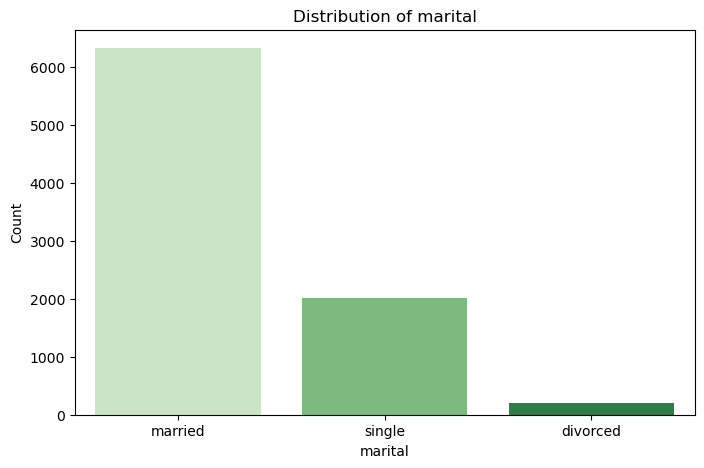

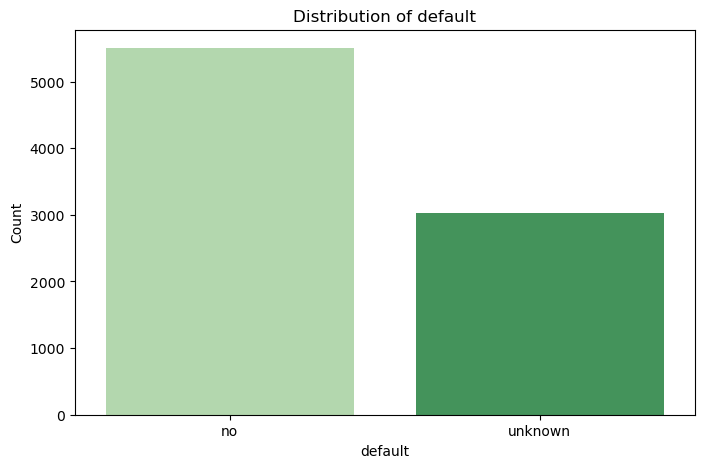

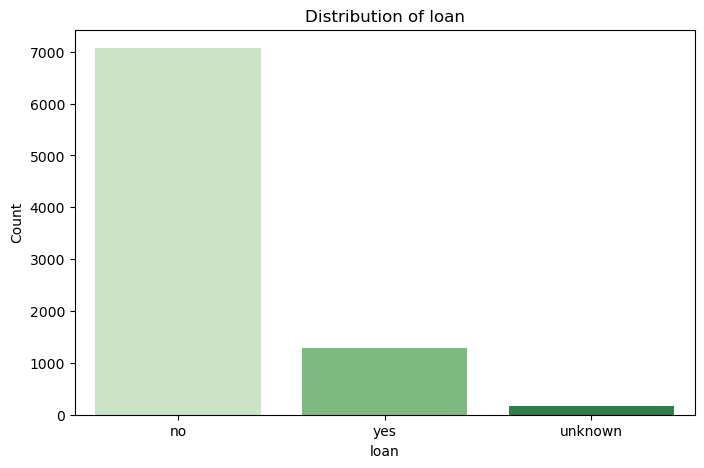

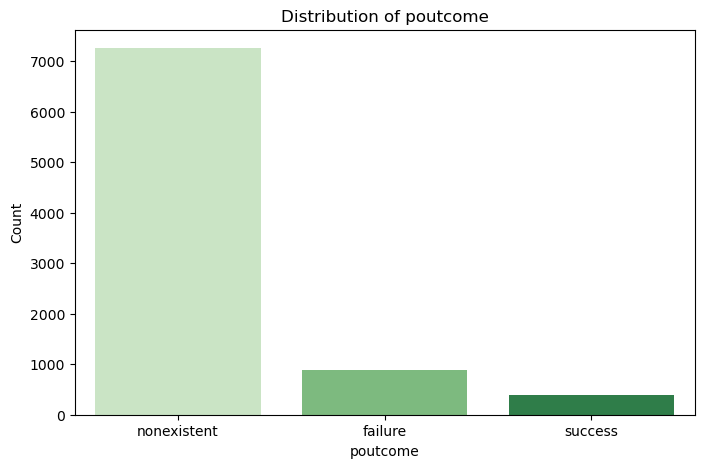

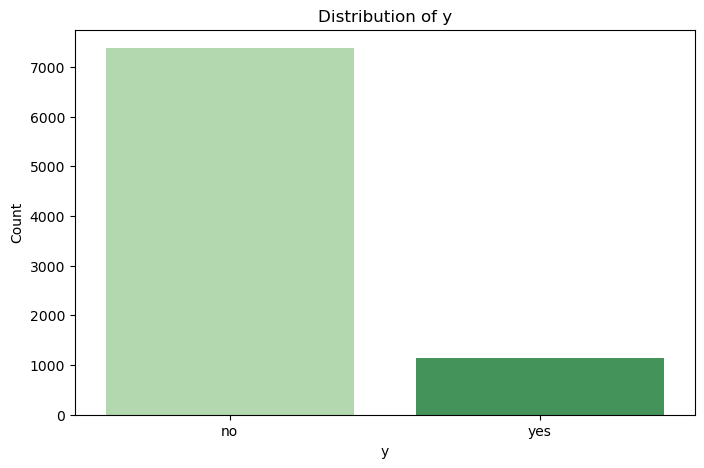

In [78]:
categorical_data= ['marital', 'default', 'loan', 'poutcome', 'y']

for column in categorical_data: 
    data = df[column].value_counts()
    plt.figure(figsize=(8, 5))  
    sns.barplot(x=data.index, y=data.values, palette= 'Greens')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# 4. Data Preprocessing

Before applying the GMM model, we need to preprocess the data. 

In [79]:
# we will use the GMM model that it's not sensitive to the outliers 

numerical_columns = ['age', 'duration', 'campaign']

iso= IsolationForest(contamination= 0.05)
outlier_prediction= iso.fit_predict(df[numerical_columns])
df['outlier'] = outlier_prediction
outliers = df[df['outlier'] == -1]
print("Number of outliers detected:", len(outliers))


Number of outliers detected: 423


# 5. Converting Categorical Features

In [80]:

month_mapping = {
    'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'feb': 2, 'jan': 1,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# Apply the mapping to the 'month' column
df['bank_month'] = df['bank_month'].map(month_mapping)



In [81]:
columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome', 'y']

hot_en= LabelEncoder()

for col in columns:
    df[col]= hot_en.fit_transform(df[col])

## 6. RFM Analysis

We perform RFM analysis to segment customers based on Recency, Frequency, and Monetary value. 

This method helps to understand customer behavior and develop more personalized marketing strategies.


In [82]:
reference= pd.to_datetime('2014-12-31')
df['date']= '2014-' + df['bank_month'].astype(str) + '-' + df['day'].astype(str)

df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df['recency'] = df.date.apply(lambda x: (reference - x).days)



In [83]:
rfm_table= df.groupby(['age', 'job', 'marital']).agg({'recency': 'min', 'balance': 'sum', 'campaign': 'count'})
rfm_table.rename(columns= {'recency': 'recency', 'balance': 'monetary', 'campaign': 'frequency'}, inplace= True)

In [84]:
rfm_table['recency']= pd.to_numeric(rfm_table['recency'], errors= 'coerce')

In [85]:
rfm_quantile= rfm_table.quantile(q= [.25, .5, .75])
rfm_quantile= rfm_quantile.to_dict()

In [86]:
rfm_quantile

{'recency': {0.25: 78.25, 0.5: 153.5, 0.75: 209.0},
 'monetary': {0.25: 1616.0, 0.5: 6082.0, 0.75: 24440.25},
 'frequency': {0.25: 2.0, 0.5: 6.0, 0.75: 17.5}}

In [87]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [88]:
rfm_table['recency_quantile']= rfm_table['recency'].apply(RScore, args= ('recency', rfm_quantile))
rfm_table['frequency_quantile']= rfm_table['frequency'].apply(FMScore, args= ('frequency', rfm_quantile))
rfm_table['monetary_quantile']= rfm_table['monetary'].apply(FMScore, args= ('monetary', rfm_quantile))

In [89]:
rfm_table['rfm_segmentation']= rfm_table['recency_quantile'].astype(str)+ rfm_table['frequency_quantile'].astype(str)+ rfm_table['monetary_quantile'].astype(str)

In [90]:
rfm_table['rfm_segmentation']= pd.to_numeric(rfm_table['rfm_segmentation'], errors= 'coerce')


In [91]:

segmentation = rfm_table.groupby('rfm_segmentation').agg({'rfm_segmentation': 'count'}).T

segmentation = segmentation.rename(columns={segmentation.columns[0]: 'Count'})

segmentation


rfm_segmentation,Count,112,113,121,122,124,132,133,134,142,143,144,211,212,221,222,223,231,232,233,234,242,243,244,311,312,313,321,322,323,324,331,332,333,334,342,343,344,411,412,421,422,423,424,431,432,433,434,442,443,444
rfm_segmentation,34,4,2,10,20,1,8,10,2,3,5,1,34,6,3,16,4,1,4,11,5,2,3,10,10,5,2,3,9,3,6,2,6,13,9,3,12,21,1,2,1,1,8,5,1,8,10,11,2,16,29


In [92]:
print("Best Customers: ",len(rfm_table[rfm_table['rfm_segmentation']== 111]))
print('Loyal Customers: ',len(rfm_table[rfm_table['frequency_quantile']==1]))
print("Big Spenders: ",len(rfm_table[rfm_table['monetary_quantile']==1]))
print('Almost Lost: ', len(rfm_table[rfm_table['rfm_segmentation']== 134]))
print('Lost Customers: ',len(rfm_table[rfm_table['rfm_segmentation']== 344]))
print('Lost Cheap Customers: ',len(rfm_table[rfm_table['rfm_segmentation']== 444]))

Best Customers:  34
Loyal Customers:  100
Big Spenders:  100
Almost Lost:  2
Lost Customers:  21
Lost Cheap Customers:  29


In [93]:
label = np.empty(len(rfm_table), dtype=object)  

for i in range(len(rfm_table)):
    if rfm_table.iloc[i]['rfm_segmentation'] == 111:
        label[i] = "Best Customers"
        
    elif rfm_table.iloc[i]['rfm_segmentation'] == 134:
        label[i] = "Almost Lost"
        
    elif rfm_table.iloc[i]['rfm_segmentation'] == 344:
        label[i] = "Lost Customers"
    
    elif rfm_table.iloc[i]['rfm_segmentation'] == 444:
        label[i] = "Lost Cheap Customers"

    elif rfm_table.iloc[i]['frequency_quantile'] == 1:
        label[i] = "Loyal Customers"  
    
    elif rfm_table.iloc[i]['monetary_quantile'] == 1:
        label[i] = "Big Spenders"   
        
    else:
        label[i] = "Others"


rfm_table['label'] = label

In [94]:
rfm_table.reset_index(inplace= True)

In [95]:
rfm_table.label.value_counts()

label
Others                  225
Loyal Customers          66
Best Customers           34
Lost Cheap Customers     29
Lost Customers           21
Big Spenders             21
Almost Lost               2
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='age'>

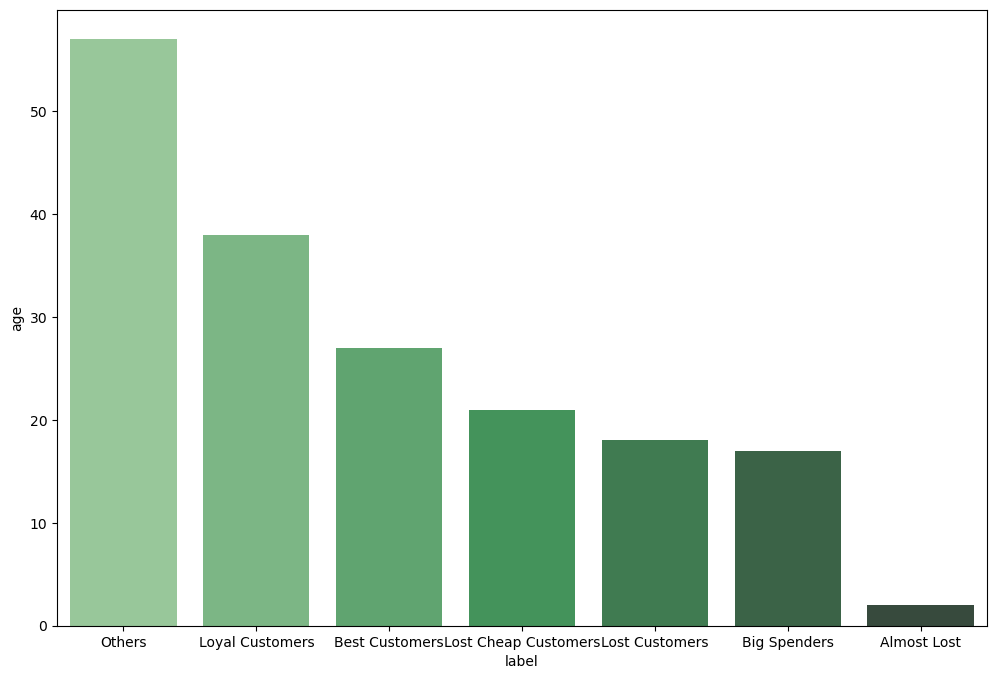

In [96]:
unique_counts = rfm_table.groupby('label')[['age', 'job', 'marital']].nunique().sort_values(by='age', ascending=False).reset_index()
plt.figure(figsize=(12,8))

sns.barplot(data=unique_counts, x="label", y="age", palette = "Greens_d")

In [97]:
rfm_cluster= rfm_table.drop('label', axis= 1)


## 7. Apply GMM for Advanced Segmentation

Next, we apply the Gaussian Mixture Model (GMM) to improve segmentation. 
GMM allows us to handle more complex cluster shapes and distributional characteristics within the data.


In [ ]:
result = []

covariance = ['tied', 'full', 'diag', 'spherical']
clusters = np.arange(1, 5)

for i in covariance:
    for n in clusters:
        gm = GaussianMixture(covariance_type=i, n_components=n, random_state=42)
        pred_clust = gm.fit_predict(rfm_cluster)

        if len(np.unique(pred_clust)) >= 2:
            silhouette = metrics.silhouette_score(rfm_cluster, pred_clust)
            daviesB = metrics.davies_bouldin_score(rfm_cluster, pred_clust)

            result.append({
                'covariance type': i,
                'clusters number': n,
                'silhouette score': silhouette,
                'davies bouldin score': daviesB
            })


results_ = pd.DataFrame(result)

top_results = results_.sort_values(by=["silhouette score"], ascending=False).head(10)
top_results


,covariance type,clusters number,silhouette score,davies bouldin score
0,tied,2,0.880641,0.531191
1,tied,3,0.835230,0.373958
2,tied,4,0.778177,0.380023
5,full,4,0.734629,0.425106
4,full,3,0.718908,0.542925
3,full,2,0.697466,0.796899
6,diag,2,0.697466,0.796899
7,diag,3,0.610098,1.848174
9,spherical,2,0.581128,0.863011
8,diag,4,0.515991,3.275438


## 8. Apply KMeans for Segmentation

we apply the KMeans to improve segmentation. 
then we will compare both models and see which perfom better.

In [99]:
score= []

for i in range(2, 8):
    kmean= KMeans(n_clusters= i, random_state= 42)
    label= kmean.fit_predict(rfm_cluster)

    sil_score= metrics.silhouette_score(rfm_cluster, label)
    dav_score= metrics.davies_bouldin_score(rfm_cluster, label)
    score.append({
        'clusters number': i,
        'silhouette score': sil_score,
        'davies bouldin score': dav_score
    })

kmean_result = results_.sort_values(by=["silhouette score"], ascending=False)
print(kmean_result)

   covariance type  clusters number  silhouette score  davies bouldin score
0             tied                2          0.880641              0.531191
1             tied                3          0.835230              0.373958
2             tied                4          0.778177              0.380023
5             full                4          0.734629              0.425106
4             full                3          0.718908              0.542925
3             full                2          0.697466              0.796899
6             diag                2          0.697466              0.796899
7             diag                3          0.610098              1.848174
9        spherical                2          0.581128              0.863011
8             diag                4          0.515991              3.275438
10       spherical                3          0.462465              0.743767
11       spherical                4          0.459860              0.575870


# 9. Visualize Customer Segments

Finally, we use dimensionality reduction techniques like PCA to visualize and compare the customer segments using kmeans and GMM model. 

This helps in understanding the distribution and overlap between different segments.



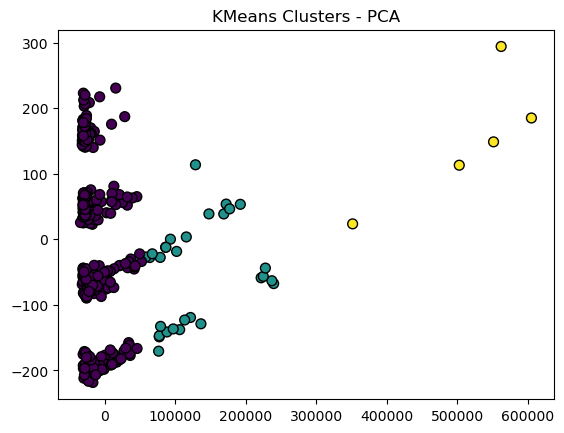

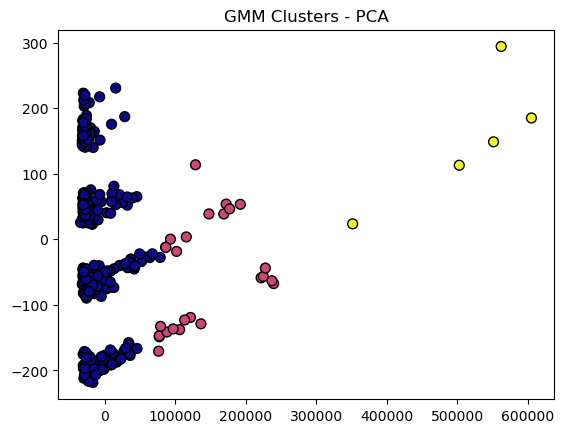

In [100]:
from sklearn.decomposition import PCA

pca= PCA(n_components= 3)
rfm_pca= pca.fit_transform(rfm_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_cluster)

plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("KMeans Clusters - PCA")
plt.show()


gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=42)
gmm_labels = gmm.fit_predict(rfm_cluster)


plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=gmm_labels, cmap='plasma', marker='o', edgecolor='k', s=50)
plt.title("GMM Clusters - PCA")
plt.show()


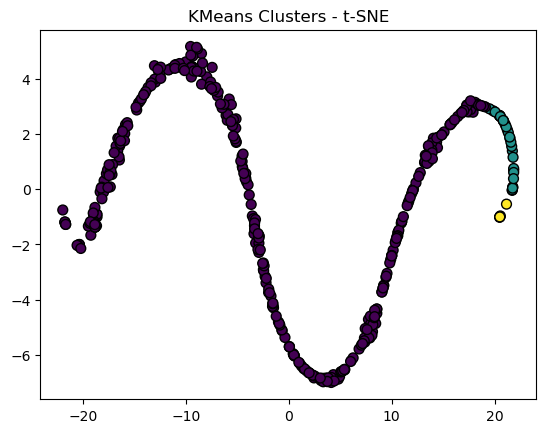

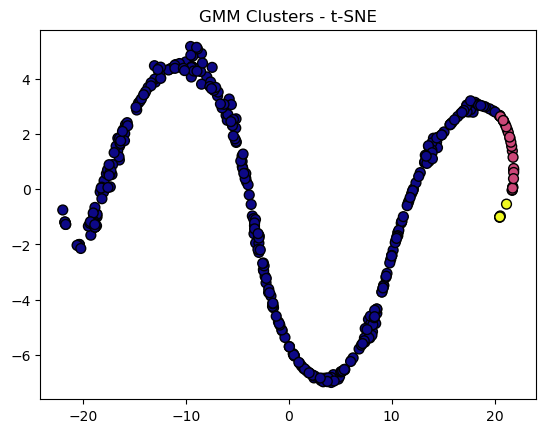

In [105]:

tsne = TSNE(n_components=3, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_cluster)

# Visualize clusters for KMeans
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("KMeans Clusters - t-SNE")
plt.show()

# Visualize clusters for GMM
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=gmm_labels, cmap='plasma', marker='o', edgecolor='k', s=50)
plt.title("GMM Clusters - t-SNE")
plt.show()


We see the result is the same with both models. so we will go with GMM model

In [102]:
pca= PCA(n_components= 3)
rfm_pca= pca.fit_transform(rfm_cluster)

gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=42)
gmm_labels = gmm.fit_predict(rfm_cluster)

rfm_table['Cluster']= gmm_labels

In [103]:

numerical_features = ['age', 'monetary', 'frequency','recency']

rfm_table.groupby('Cluster')[numerical_features].mean()

,age,monetary,frequency,recency
Cluster,,,,
0,45.086957,14401.016304,12.730978,153.633152
1,43.400000,171375.640000,106.440000,77.280000
2,44.800000,545358.800000,236.400000,61.000000


# Customer Segmentation Analysis

For the full interpretation of the segments, check the [README.md](README.md)
